# 0. Import Dependencies

In [ ]:
pip list

In [ ]:
#Install Mario Environment
!pip install gym_super_mario_bros==7.3.0 nes_py

In [ ]:
#Install Pythorch
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

In [ ]:
#Install stable baselines for RL
!pip install stable-baselines3[extra]

In [2]:
#Check if CUDA works in gpu
import torch
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1060'

# 1.Setup Mario


In [2]:
# Import the game
import gym_super_mario_bros
# Import the Joypad Wrapper
from nes_py.wrappers import JoypadSpace
# Import the SIMPLIFIED controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
#Import gym spaces
from gym.spaces import Discrete, Box

In [6]:
#Setup Game
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

In [ ]:
#Create a Flag - Restart or Not
done = True
#Loop each frame in the game
for step in range(1000):
    if done:
        #Start the game
        env.reset()
        #Do random actions
    state, reward, done, info = env.step(env.action_space.sample())
    #Show the game on the screen
    env.render()

env.close()

# 2. Preprocess Environment


In [3]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import time

# Import the game
import gym_super_mario_bros
# Import the Joypad Wrapper
from nes_py.wrappers import JoypadSpace
# Import the SIMPLIFIED controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
#Import gym spaces
from gym.spaces import Discrete, Box

# Import Frame Stacker Wrapper and GrayScaling Wrapper
from gym.wrappers import GrayScaleObservation
# Import Vectorization Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
#Make custom environment
from stable_baselines3.common.env_util import make_vec_env

#Wrap easier
from stable_baselines3.common.atari_wrappers import AtariWrapper

In [4]:
class CustomReward(gym.Wrapper):
    def __init__(self, env):
        super(CustomReward, self).__init__(env)
        self._current_score = 0
        

    def step(self, action):
        state, reward, done, info = self.env.step(action)
        reward += (info['score'] - self._current_score) / 40.0
        self._current_score = info['score']
        if done:
            if info['flag_get']:
                print('We got it!!!!!')
                reward += 350.0
            else:
                reward -= 50.0
        return state, reward / 10.0, done, info
    
    
    #Reset the environment and return the initial observation.
    def reset(self):
        return self.env.reset()

In [5]:
def mario_wrapper(env):
    #1. Simplify the controls
    env = JoypadSpace(env, SIMPLE_MOVEMENT)
    #2. AtariWrapper DO A LOT OF THINGS (Grayscale, resize, FrameSkip etc.)
    env = AtariWrapper(env, terminal_on_life_loss=False, clip_reward=False)
    env = gym.wrappers.ResizeObservation(env, (240, 256))
    #3. Custom Reward System
    env = CustomReward(env)
    
    return env

In [6]:
env = make_vec_env('SuperMarioBros-v0', seed=42, wrapper_class=mario_wrapper)
#4. Stack the frames
env = VecFrameStack(env, 4, channels_order="last")

In [14]:
env.render()

In [7]:
state = env.reset()
print('state:', state.shape) #Color scale, height, width, num of stacks

state: (1, 240, 256, 4)


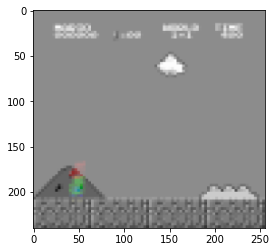

In [25]:
from matplotlib import pyplot as plt
plt.imshow(cv2.cvtColor(state[0], cv2.COLOR_BGR2RGB))

In [22]:
state, reward, done, info = env.step([env.action_space.sample()])

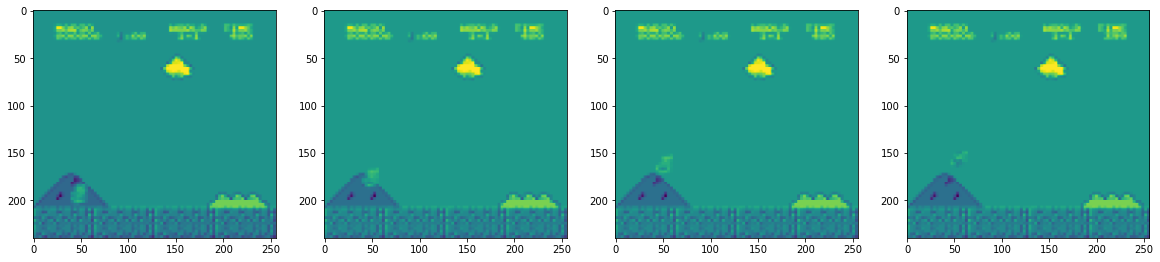

In [27]:
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

In [15]:
env.close()

# 3. Train the RL Model

In [8]:
#Import os for file path managment
import os
#Import PPO and DQN for algos
from stable_baselines3 import PPO, DQN
#Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

In [9]:
#Save our models every x steps
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [10]:
CHECKPOINT_DIR = './train/PPO'
LOG_DIR = './logs/'

In [10]:
callback = TrainAndLoggingCallback(check_freq=100000, save_path=CHECKPOINT_DIR)

In [ ]:
#AI model PPO
model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.00001, n_steps=8192, clip_range=.1, gamma=.95, gae_lambda=.9)

In [16]:
#AI model DQN
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.00001, batch_size=64, buffer_size=10000, learning_starts=5000, gamma=.95)

Using cuda device
Wrapping the env in a VecTransposeImage.


In [17]:
#Train the AI model, this is where the AI model starts to learn
model.learn(total_timesteps=2000000, callback=callback)

Logging to ./logs/DQN_1


C:\Users\tarik\OneDrive\Masaüstü\Python\Python ile Veri Bilimi\Nicholas Renotte - Youtube Tutorials\MarioAI\marioai\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87e+03 |
|    ep_rew_mean      | 1.37e+03 |
|    exploration_rate | 0.982    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 126      |
|    time_elapsed     | 30       |
|    total_timesteps  | 3855     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.39e+03 |
|    ep_rew_mean      | 1.58e+03 |
|    exploration_rate | 0.968    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 68       |
|    time_elapsed     | 98       |
|    total_timesteps  | 6749     |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0318   |
|    n_updates        | 437      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean    

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.53e+03 |
|    ep_rew_mean      | 1.66e+03 |
|    exploration_rate | 0.716    |
| time/               |          |
|    episodes         | 68       |
|    fps              | 34       |
|    time_elapsed     | 1721     |
|    total_timesteps  | 59753    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.119    |
|    n_updates        | 13688    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.51e+03 |
|    ep_rew_mean      | 1.69e+03 |
|    exploration_rate | 0.701    |
| time/               |          |
|    episodes         | 72       |
|    fps              | 34       |
|    time_elapsed     | 1818     |
|    total_timesteps  | 62872    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0684   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.81e+03 |
|    ep_rew_mean      | 1.75e+03 |
|    exploration_rate | 0.535    |
| time/               |          |
|    episodes         | 132      |
|    fps              | 33       |
|    time_elapsed     | 2911     |
|    total_timesteps  | 97864    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.139    |
|    n_updates        | 23215    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.75e+03 |
|    ep_rew_mean      | 1.73e+03 |
|    exploration_rate | 0.531    |
| time/               |          |
|    episodes         | 136      |
|    fps              | 33       |
|    time_elapsed     | 2937     |
|    total_timesteps  | 98661    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.271    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.89e+03 |
|    ep_rew_mean      | 1.76e+03 |
|    exploration_rate | 0.402    |
| time/               |          |
|    episodes         | 196      |
|    fps              | 32       |
|    time_elapsed     | 3820     |
|    total_timesteps  | 125874   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.352    |
|    n_updates        | 30218    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.88e+03 |
|    ep_rew_mean      | 1.75e+03 |
|    exploration_rate | 0.393    |
| time/               |          |
|    episodes         | 200      |
|    fps              | 32       |
|    time_elapsed     | 3887     |
|    total_timesteps  | 127871   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.439    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.58e+03 |
|    ep_rew_mean      | 1.72e+03 |
|    exploration_rate | 0.288    |
| time/               |          |
|    episodes         | 260      |
|    fps              | 32       |
|    time_elapsed     | 4608     |
|    total_timesteps  | 149829   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.158    |
|    n_updates        | 36207    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.6e+03  |
|    ep_rew_mean      | 1.74e+03 |
|    exploration_rate | 0.281    |
| time/               |          |
|    episodes         | 264      |
|    fps              | 32       |
|    time_elapsed     | 4658     |
|    total_timesteps  | 151325   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.307    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.43e+03 |
|    ep_rew_mean      | 1.84e+03 |
|    exploration_rate | 0.185    |
| time/               |          |
|    episodes         | 324      |
|    fps              | 32       |
|    time_elapsed     | 5336     |
|    total_timesteps  | 171559   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.404    |
|    n_updates        | 41639    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.43e+03 |
|    ep_rew_mean      | 1.85e+03 |
|    exploration_rate | 0.179    |
| time/               |          |
|    episodes         | 328      |
|    fps              | 32       |
|    time_elapsed     | 5382     |
|    total_timesteps  | 172936   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.193    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.43e+03 |
|    ep_rew_mean      | 1.88e+03 |
|    exploration_rate | 0.0747   |
| time/               |          |
|    episodes         | 388      |
|    fps              | 31       |
|    time_elapsed     | 6127     |
|    total_timesteps  | 194798   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.145    |
|    n_updates        | 47449    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.42e+03 |
|    ep_rew_mean      | 1.88e+03 |
|    exploration_rate | 0.0683   |
| time/               |          |
|    episodes         | 392      |
|    fps              | 31       |
|    time_elapsed     | 6173     |
|    total_timesteps  | 196143   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.386    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.87e+03 |
|    ep_rew_mean      | 2e+03    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 452      |
|    fps              | 31       |
|    time_elapsed     | 7266     |
|    total_timesteps  | 227448   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.649    |
|    n_updates        | 55611    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.9e+03  |
|    ep_rew_mean      | 2e+03    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 456      |
|    fps              | 31       |
|    time_elapsed     | 7351     |
|    total_timesteps  | 229891   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.518    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.23e+03 |
|    ep_rew_mean      | 2.09e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 516      |
|    fps              | 30       |
|    time_elapsed     | 8481     |
|    total_timesteps  | 262393   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.286    |
|    n_updates        | 64348    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.36e+03 |
|    ep_rew_mean      | 2.08e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 520      |
|    fps              | 30       |
|    time_elapsed     | 8653     |
|    total_timesteps  | 267419   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.199    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.44e+03 |
|    ep_rew_mean      | 2.05e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 580      |
|    fps              | 30       |
|    time_elapsed     | 9892     |
|    total_timesteps  | 303094   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 1.18     |
|    n_updates        | 74523    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.44e+03 |
|    ep_rew_mean      | 2.05e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 584      |
|    fps              | 30       |
|    time_elapsed     | 9936     |
|    total_timesteps  | 304332   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.297    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.17e+03 |
|    ep_rew_mean      | 1.92e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 644      |
|    fps              | 30       |
|    time_elapsed     | 11113    |
|    total_timesteps  | 338382   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.311    |
|    n_updates        | 83345    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.14e+03 |
|    ep_rew_mean      | 1.91e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 648      |
|    fps              | 30       |
|    time_elapsed     | 11177    |
|    total_timesteps  | 340254   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.11     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97e+03 |
|    ep_rew_mean      | 1.81e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 708      |
|    fps              | 30       |
|    time_elapsed     | 12042    |
|    total_timesteps  | 365450   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.179    |
|    n_updates        | 90112    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.88e+03 |
|    ep_rew_mean      | 1.8e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 712      |
|    fps              | 30       |
|    time_elapsed     | 12073    |
|    total_timesteps  | 366329   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.192    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.32e+03 |
|    ep_rew_mean      | 1.64e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 772      |
|    fps              | 30       |
|    time_elapsed     | 12648    |
|    total_timesteps  | 383014   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.564    |
|    n_updates        | 94503    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.3e+03  |
|    ep_rew_mean      | 1.64e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 776      |
|    fps              | 30       |
|    time_elapsed     | 12727    |
|    total_timesteps  | 385261   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.257    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.63e+03 |
|    ep_rew_mean      | 1.67e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 836      |
|    fps              | 30       |
|    time_elapsed     | 13680    |
|    total_timesteps  | 412816   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0957   |
|    n_updates        | 101953   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.72e+03 |
|    ep_rew_mean      | 1.68e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 840      |
|    fps              | 30       |
|    time_elapsed     | 13785    |
|    total_timesteps  | 415787   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.242    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.18e+03 |
|    ep_rew_mean      | 1.83e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 900      |
|    fps              | 30       |
|    time_elapsed     | 14922    |
|    total_timesteps  | 448239   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.263    |
|    n_updates        | 110809   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.25e+03 |
|    ep_rew_mean      | 1.86e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 904      |
|    fps              | 30       |
|    time_elapsed     | 15014    |
|    total_timesteps  | 450905   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.128    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84e+03 |
|    ep_rew_mean      | 1.99e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 964      |
|    fps              | 29       |
|    time_elapsed     | 15838    |
|    total_timesteps  | 474375   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.757    |
|    n_updates        | 117343   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.83e+03 |
|    ep_rew_mean      | 2e+03    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 968      |
|    fps              | 29       |
|    time_elapsed     | 15907    |
|    total_timesteps  | 476371   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.259    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.37e+03 |
|    ep_rew_mean      | 1.92e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1028     |
|    fps              | 29       |
|    time_elapsed     | 16519    |
|    total_timesteps  | 493801   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.242    |
|    n_updates        | 122200   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.31e+03 |
|    ep_rew_mean      | 1.87e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1032     |
|    fps              | 29       |
|    time_elapsed     | 16541    |
|    total_timesteps  | 494438   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.46     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.4e+03  |
|    ep_rew_mean      | 1.9e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1092     |
|    fps              | 29       |
|    time_elapsed     | 17356    |
|    total_timesteps  | 517504   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.388    |
|    n_updates        | 128125   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.4e+03  |
|    ep_rew_mean      | 1.9e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1096     |
|    fps              | 29       |
|    time_elapsed     | 17398    |
|    total_timesteps  | 518665   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.265    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.47e+03 |
|    ep_rew_mean      | 1.95e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1156     |
|    fps              | 29       |
|    time_elapsed     | 18097    |
|    total_timesteps  | 538603   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.107    |
|    n_updates        | 133400   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.48e+03 |
|    ep_rew_mean      | 1.96e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1160     |
|    fps              | 29       |
|    time_elapsed     | 18148    |
|    total_timesteps  | 540031   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.406    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.31e+03 |
|    ep_rew_mean      | 1.95e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1220     |
|    fps              | 29       |
|    time_elapsed     | 18829    |
|    total_timesteps  | 559382   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.187    |
|    n_updates        | 138595   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.3e+03  |
|    ep_rew_mean      | 1.94e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1224     |
|    fps              | 29       |
|    time_elapsed     | 18861    |
|    total_timesteps  | 560314   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.272    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.12e+03 |
|    ep_rew_mean      | 1.96e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1284     |
|    fps              | 29       |
|    time_elapsed     | 19449    |
|    total_timesteps  | 576928   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.856    |
|    n_updates        | 142981   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.13e+03 |
|    ep_rew_mean      | 1.98e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1288     |
|    fps              | 29       |
|    time_elapsed     | 19489    |
|    total_timesteps  | 578069   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.691    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.02e+03 |
|    ep_rew_mean      | 1.94e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1348     |
|    fps              | 29       |
|    time_elapsed     | 20009    |
|    total_timesteps  | 592834   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.321    |
|    n_updates        | 146958   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.01e+03 |
|    ep_rew_mean      | 1.91e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1352     |
|    fps              | 29       |
|    time_elapsed     | 20042    |
|    total_timesteps  | 593755   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.317    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.14e+03 |
|    ep_rew_mean      | 2.03e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1412     |
|    fps              | 29       |
|    time_elapsed     | 20673    |
|    total_timesteps  | 611595   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.376    |
|    n_updates        | 151648   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.13e+03 |
|    ep_rew_mean      | 2.03e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1416     |
|    fps              | 29       |
|    time_elapsed     | 20708    |
|    total_timesteps  | 612580   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.329    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.14e+03 |
|    ep_rew_mean      | 2.06e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1476     |
|    fps              | 29       |
|    time_elapsed     | 21263    |
|    total_timesteps  | 628256   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.248    |
|    n_updates        | 155813   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.09e+03 |
|    ep_rew_mean      | 2.04e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1480     |
|    fps              | 29       |
|    time_elapsed     | 21298    |
|    total_timesteps  | 629277   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.357    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.05e+03 |
|    ep_rew_mean      | 2.06e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1540     |
|    fps              | 29       |
|    time_elapsed     | 21834    |
|    total_timesteps  | 644508   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.208    |
|    n_updates        | 159876   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.05e+03 |
|    ep_rew_mean      | 2.05e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1544     |
|    fps              | 29       |
|    time_elapsed     | 21869    |
|    total_timesteps  | 645489   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.347    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.14e+03 |
|    ep_rew_mean      | 2.02e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1604     |
|    fps              | 29       |
|    time_elapsed     | 22485    |
|    total_timesteps  | 662982   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.362    |
|    n_updates        | 164495   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.13e+03 |
|    ep_rew_mean      | 2e+03    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1608     |
|    fps              | 29       |
|    time_elapsed     | 22522    |
|    total_timesteps  | 664027   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.632    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.19e+03 |
|    ep_rew_mean      | 2.1e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1668     |
|    fps              | 29       |
|    time_elapsed     | 23118    |
|    total_timesteps  | 681000   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.364    |
|    n_updates        | 168999   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.2e+03  |
|    ep_rew_mean      | 2.11e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1672     |
|    fps              | 29       |
|    time_elapsed     | 23160    |
|    total_timesteps  | 682209   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.383    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.18e+03 |
|    ep_rew_mean      | 2.17e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1732     |
|    fps              | 29       |
|    time_elapsed     | 23773    |
|    total_timesteps  | 699657   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.545    |
|    n_updates        | 173664   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.17e+03 |
|    ep_rew_mean      | 2.15e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1736     |
|    fps              | 29       |
|    time_elapsed     | 23811    |
|    total_timesteps  | 700710   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.18     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.17e+03 |
|    ep_rew_mean      | 2.13e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1796     |
|    fps              | 29       |
|    time_elapsed     | 24418    |
|    total_timesteps  | 717909   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.777    |
|    n_updates        | 178227   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.18e+03 |
|    ep_rew_mean      | 2.14e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1800     |
|    fps              | 29       |
|    time_elapsed     | 24455    |
|    total_timesteps  | 718940   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.292    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 977      |
|    ep_rew_mean      | 2.02e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1860     |
|    fps              | 29       |
|    time_elapsed     | 24954    |
|    total_timesteps  | 733148   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.11     |
|    n_updates        | 182036   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 977      |
|    ep_rew_mean      | 2.02e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1864     |
|    fps              | 29       |
|    time_elapsed     | 24991    |
|    total_timesteps  | 734236   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.237    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.05e+03 |
|    ep_rew_mean      | 2.17e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1924     |
|    fps              | 29       |
|    time_elapsed     | 25566    |
|    total_timesteps  | 750648   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.389    |
|    n_updates        | 186411   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.05e+03 |
|    ep_rew_mean      | 2.18e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1928     |
|    fps              | 29       |
|    time_elapsed     | 25606    |
|    total_timesteps  | 751771   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.239    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.16e+03 |
|    ep_rew_mean      | 2.24e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1988     |
|    fps              | 29       |
|    time_elapsed     | 26217    |
|    total_timesteps  | 769226   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.407    |
|    n_updates        | 191056   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.16e+03 |
|    ep_rew_mean      | 2.24e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1992     |
|    fps              | 29       |
|    time_elapsed     | 26252    |
|    total_timesteps  | 770235   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.241    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.42e+03 |
|    ep_rew_mean      | 2.33e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2052     |
|    fps              | 29       |
|    time_elapsed     | 27070    |
|    total_timesteps  | 793469   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.183    |
|    n_updates        | 197117   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.42e+03 |
|    ep_rew_mean      | 2.33e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2056     |
|    fps              | 29       |
|    time_elapsed     | 27112    |
|    total_timesteps  | 794663   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.585    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.34e+03 |
|    ep_rew_mean      | 2.27e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2116     |
|    fps              | 29       |
|    time_elapsed     | 27794    |
|    total_timesteps  | 812739   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.65     |
|    n_updates        | 201934   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.34e+03 |
|    ep_rew_mean      | 2.26e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2120     |
|    fps              | 29       |
|    time_elapsed     | 27839    |
|    total_timesteps  | 813851   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.154    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.18e+03 |
|    ep_rew_mean      | 2.2e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2180     |
|    fps              | 29       |
|    time_elapsed     | 28475    |
|    total_timesteps  | 830146   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.285    |
|    n_updates        | 206286   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.17e+03 |
|    ep_rew_mean      | 2.19e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2184     |
|    fps              | 29       |
|    time_elapsed     | 28508    |
|    total_timesteps  | 830977   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.563    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.22e+03 |
|    ep_rew_mean      | 2.31e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2244     |
|    fps              | 29       |
|    time_elapsed     | 29254    |
|    total_timesteps  | 849861   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.167    |
|    n_updates        | 211215   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.21e+03 |
|    ep_rew_mean      | 2.29e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2248     |
|    fps              | 29       |
|    time_elapsed     | 29293    |
|    total_timesteps  | 850833   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.16     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.22e+03 |
|    ep_rew_mean      | 2.29e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2308     |
|    fps              | 28       |
|    time_elapsed     | 30018    |
|    total_timesteps  | 869072   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.232    |
|    n_updates        | 216017   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.21e+03 |
|    ep_rew_mean      | 2.27e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2312     |
|    fps              | 28       |
|    time_elapsed     | 30054    |
|    total_timesteps  | 869937   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.148    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.3e+03  |
|    ep_rew_mean      | 2.21e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2372     |
|    fps              | 28       |
|    time_elapsed     | 30907    |
|    total_timesteps  | 890990   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.2      |
|    n_updates        | 221497   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.43e+03 |
|    ep_rew_mean      | 2.23e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2376     |
|    fps              | 28       |
|    time_elapsed     | 31071    |
|    total_timesteps  | 895223   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.323    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.52e+03 |
|    ep_rew_mean      | 2.31e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2436     |
|    fps              | 28       |
|    time_elapsed     | 31799    |
|    total_timesteps  | 913803   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.14     |
|    n_updates        | 227200   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.51e+03 |
|    ep_rew_mean      | 2.3e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2440     |
|    fps              | 28       |
|    time_elapsed     | 31836    |
|    total_timesteps  | 914798   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.148    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.28e+03 |
|    ep_rew_mean      | 2.38e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2500     |
|    fps              | 28       |
|    time_elapsed     | 32529    |
|    total_timesteps  | 933620   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.218    |
|    n_updates        | 232154   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.29e+03 |
|    ep_rew_mean      | 2.4e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2504     |
|    fps              | 28       |
|    time_elapsed     | 32573    |
|    total_timesteps  | 934853   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.111    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.26e+03 |
|    ep_rew_mean      | 2.42e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2564     |
|    fps              | 28       |
|    time_elapsed     | 33253    |
|    total_timesteps  | 953743   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.13     |
|    n_updates        | 237185   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.26e+03 |
|    ep_rew_mean      | 2.44e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2568     |
|    fps              | 28       |
|    time_elapsed     | 33312    |
|    total_timesteps  | 955385   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.203    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.46e+03 |
|    ep_rew_mean      | 2.55e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2628     |
|    fps              | 28       |
|    time_elapsed     | 34124    |
|    total_timesteps  | 977828   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.184    |
|    n_updates        | 243206   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.48e+03 |
|    ep_rew_mean      | 2.56e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2632     |
|    fps              | 28       |
|    time_elapsed     | 34174    |
|    total_timesteps  | 979252   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.18     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.55e+03 |
|    ep_rew_mean      | 2.52e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2692     |
|    fps              | 28       |
|    time_elapsed     | 35016    |
|    total_timesteps  | 1002499  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.27     |
|    n_updates        | 249374   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.56e+03 |
|    ep_rew_mean      | 2.54e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2696     |
|    fps              | 28       |
|    time_elapsed     | 35076    |
|    total_timesteps  | 1004099  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.104    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.54e+03 |
|    ep_rew_mean      | 2.55e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2756     |
|    fps              | 28       |
|    time_elapsed     | 35963    |
|    total_timesteps  | 1027993  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.193    |
|    n_updates        | 255748   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.56e+03 |
|    ep_rew_mean      | 2.57e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2760     |
|    fps              | 28       |
|    time_elapsed     | 36019    |
|    total_timesteps  | 1029537  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.556    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.54e+03 |
|    ep_rew_mean      | 2.64e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2820     |
|    fps              | 28       |
|    time_elapsed     | 36842    |
|    total_timesteps  | 1052145  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.12     |
|    n_updates        | 261786   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.51e+03 |
|    ep_rew_mean      | 2.64e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2824     |
|    fps              | 28       |
|    time_elapsed     | 36906    |
|    total_timesteps  | 1053916  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.536    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.27e+03 |
|    ep_rew_mean      | 2.44e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2884     |
|    fps              | 28       |
|    time_elapsed     | 37541    |
|    total_timesteps  | 1071344  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.537    |
|    n_updates        | 266585   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.27e+03 |
|    ep_rew_mean      | 2.45e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2888     |
|    fps              | 28       |
|    time_elapsed     | 37581    |
|    total_timesteps  | 1072439  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.472    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.21e+03 |
|    ep_rew_mean      | 2.34e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2948     |
|    fps              | 28       |
|    time_elapsed     | 38209    |
|    total_timesteps  | 1089795  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.272    |
|    n_updates        | 271198   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.13e+03 |
|    ep_rew_mean      | 2.31e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2952     |
|    fps              | 28       |
|    time_elapsed     | 38244    |
|    total_timesteps  | 1090763  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.308    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.28e+03 |
|    ep_rew_mean      | 2.37e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3012     |
|    fps              | 28       |
|    time_elapsed     | 39039    |
|    total_timesteps  | 1112514  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.162    |
|    n_updates        | 276878   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.29e+03 |
|    ep_rew_mean      | 2.39e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3016     |
|    fps              | 28       |
|    time_elapsed     | 39080    |
|    total_timesteps  | 1113658  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.294    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.26e+03 |
|    ep_rew_mean      | 2.47e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3076     |
|    fps              | 28       |
|    time_elapsed     | 39736    |
|    total_timesteps  | 1131332  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.156    |
|    n_updates        | 281582   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.27e+03 |
|    ep_rew_mean      | 2.49e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3080     |
|    fps              | 28       |
|    time_elapsed     | 39779    |
|    total_timesteps  | 1132545  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.183    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.24e+03 |
|    ep_rew_mean      | 2.5e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3140     |
|    fps              | 28       |
|    time_elapsed     | 40461    |
|    total_timesteps  | 1151217  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.289    |
|    n_updates        | 286554   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.26e+03 |
|    ep_rew_mean      | 2.54e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3144     |
|    fps              | 28       |
|    time_elapsed     | 40505    |
|    total_timesteps  | 1152430  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.157    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.2e+03  |
|    ep_rew_mean      | 2.43e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3204     |
|    fps              | 28       |
|    time_elapsed     | 41165    |
|    total_timesteps  | 1170699  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.133    |
|    n_updates        | 291424   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.21e+03 |
|    ep_rew_mean      | 2.44e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3208     |
|    fps              | 28       |
|    time_elapsed     | 41208    |
|    total_timesteps  | 1171866  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.574    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.25e+03 |
|    ep_rew_mean      | 2.39e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3268     |
|    fps              | 28       |
|    time_elapsed     | 41871    |
|    total_timesteps  | 1190246  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.358    |
|    n_updates        | 296311   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.24e+03 |
|    ep_rew_mean      | 2.38e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3272     |
|    fps              | 28       |
|    time_elapsed     | 41909    |
|    total_timesteps  | 1191311  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.347    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.3e+03  |
|    ep_rew_mean      | 2.5e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3332     |
|    fps              | 28       |
|    time_elapsed     | 42629    |
|    total_timesteps  | 1210877  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.233    |
|    n_updates        | 301469   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.3e+03  |
|    ep_rew_mean      | 2.5e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3336     |
|    fps              | 28       |
|    time_elapsed     | 42674    |
|    total_timesteps  | 1211983  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.272    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.2e+03  |
|    ep_rew_mean      | 2.53e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3396     |
|    fps              | 28       |
|    time_elapsed     | 43422    |
|    total_timesteps  | 1230092  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.23     |
|    n_updates        | 306272   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.23e+03 |
|    ep_rew_mean      | 2.54e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3400     |
|    fps              | 28       |
|    time_elapsed     | 43517    |
|    total_timesteps  | 1232367  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.376    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.43e+03 |
|    ep_rew_mean      | 2.59e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3460     |
|    fps              | 28       |
|    time_elapsed     | 44435    |
|    total_timesteps  | 1255055  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.138    |
|    n_updates        | 312513   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.44e+03 |
|    ep_rew_mean      | 2.59e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3464     |
|    fps              | 28       |
|    time_elapsed     | 44475    |
|    total_timesteps  | 1256114  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0947   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.51e+03 |
|    ep_rew_mean      | 2.64e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3524     |
|    fps              | 28       |
|    time_elapsed     | 45288    |
|    total_timesteps  | 1277641  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.46     |
|    n_updates        | 318160   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.51e+03 |
|    ep_rew_mean      | 2.6e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3528     |
|    fps              | 28       |
|    time_elapsed     | 45344    |
|    total_timesteps  | 1279131  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.15     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.29e+03 |
|    ep_rew_mean      | 2.53e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3588     |
|    fps              | 28       |
|    time_elapsed     | 46036    |
|    total_timesteps  | 1298129  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0913   |
|    n_updates        | 323282   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.27e+03 |
|    ep_rew_mean      | 2.52e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3592     |
|    fps              | 28       |
|    time_elapsed     | 46079    |
|    total_timesteps  | 1299326  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0629   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.26e+03 |
|    ep_rew_mean      | 2.47e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3652     |
|    fps              | 28       |
|    time_elapsed     | 46805    |
|    total_timesteps  | 1319179  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.429    |
|    n_updates        | 328544   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.25e+03 |
|    ep_rew_mean      | 2.45e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3656     |
|    fps              | 28       |
|    time_elapsed     | 46837    |
|    total_timesteps  | 1320059  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.178    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.29e+03 |
|    ep_rew_mean      | 2.45e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3716     |
|    fps              | 28       |
|    time_elapsed     | 47566    |
|    total_timesteps  | 1340090  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.409    |
|    n_updates        | 333772   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.28e+03 |
|    ep_rew_mean      | 2.44e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3720     |
|    fps              | 28       |
|    time_elapsed     | 47599    |
|    total_timesteps  | 1341016  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.158    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.16e+03 |
|    ep_rew_mean      | 2.33e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3780     |
|    fps              | 28       |
|    time_elapsed     | 48170    |
|    total_timesteps  | 1356879  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.133    |
|    n_updates        | 337969   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.15e+03 |
|    ep_rew_mean      | 2.32e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3784     |
|    fps              | 28       |
|    time_elapsed     | 48208    |
|    total_timesteps  | 1357921  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.116    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.06e+03 |
|    ep_rew_mean      | 2.32e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3844     |
|    fps              | 28       |
|    time_elapsed     | 48777    |
|    total_timesteps  | 1373660  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.112    |
|    n_updates        | 342164   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.06e+03 |
|    ep_rew_mean      | 2.33e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3848     |
|    fps              | 28       |
|    time_elapsed     | 48818    |
|    total_timesteps  | 1374804  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.523    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.1e+03  |
|    ep_rew_mean      | 2.3e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3908     |
|    fps              | 28       |
|    time_elapsed     | 49444    |
|    total_timesteps  | 1392058  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.545    |
|    n_updates        | 346764   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.11e+03 |
|    ep_rew_mean      | 2.31e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3912     |
|    fps              | 28       |
|    time_elapsed     | 49493    |
|    total_timesteps  | 1393420  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.123    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.17e+03 |
|    ep_rew_mean      | 2.35e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3972     |
|    fps              | 28       |
|    time_elapsed     | 50125    |
|    total_timesteps  | 1410694  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.107    |
|    n_updates        | 351423   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.18e+03 |
|    ep_rew_mean      | 2.36e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3976     |
|    fps              | 28       |
|    time_elapsed     | 50165    |
|    total_timesteps  | 1411805  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.203    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.16e+03 |
|    ep_rew_mean      | 2.4e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4036     |
|    fps              | 28       |
|    time_elapsed     | 50836    |
|    total_timesteps  | 1430291  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.278    |
|    n_updates        | 356322   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.15e+03 |
|    ep_rew_mean      | 2.38e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4040     |
|    fps              | 28       |
|    time_elapsed     | 50866    |
|    total_timesteps  | 1431113  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.217    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.19e+03 |
|    ep_rew_mean      | 2.36e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4100     |
|    fps              | 28       |
|    time_elapsed     | 51587    |
|    total_timesteps  | 1451057  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.105    |
|    n_updates        | 361514   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.28e+03 |
|    ep_rew_mean      | 2.38e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4104     |
|    fps              | 28       |
|    time_elapsed     | 51695    |
|    total_timesteps  | 1454033  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.176    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.38e+03 |
|    ep_rew_mean      | 2.52e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4164     |
|    fps              | 28       |
|    time_elapsed     | 52327    |
|    total_timesteps  | 1471288  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0932   |
|    n_updates        | 366571   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.37e+03 |
|    ep_rew_mean      | 2.55e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4168     |
|    fps              | 28       |
|    time_elapsed     | 52426    |
|    total_timesteps  | 1474005  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.118    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.25e+03 |
|    ep_rew_mean      | 2.62e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4228     |
|    fps              | 28       |
|    time_elapsed     | 53059    |
|    total_timesteps  | 1491664  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.541    |
|    n_updates        | 371665   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.23e+03 |
|    ep_rew_mean      | 2.58e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4232     |
|    fps              | 28       |
|    time_elapsed     | 53085    |
|    total_timesteps  | 1492365  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.148    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.23e+03 |
|    ep_rew_mean      | 2.58e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4292     |
|    fps              | 28       |
|    time_elapsed     | 53791    |
|    total_timesteps  | 1511692  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.224    |
|    n_updates        | 376672   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.22e+03 |
|    ep_rew_mean      | 2.58e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4296     |
|    fps              | 28       |
|    time_elapsed     | 53824    |
|    total_timesteps  | 1512620  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.223    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.2e+03  |
|    ep_rew_mean      | 2.55e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4356     |
|    fps              | 28       |
|    time_elapsed     | 54460    |
|    total_timesteps  | 1529934  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.359    |
|    n_updates        | 381233   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.19e+03 |
|    ep_rew_mean      | 2.52e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4360     |
|    fps              | 28       |
|    time_elapsed     | 54489    |
|    total_timesteps  | 1530749  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.115    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.24e+03 |
|    ep_rew_mean      | 2.49e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4420     |
|    fps              | 28       |
|    time_elapsed     | 55197    |
|    total_timesteps  | 1550159  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.219    |
|    n_updates        | 386289   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.24e+03 |
|    ep_rew_mean      | 2.49e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4424     |
|    fps              | 28       |
|    time_elapsed     | 55249    |
|    total_timesteps  | 1551557  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0952   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.37e+03 |
|    ep_rew_mean      | 2.66e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4484     |
|    fps              | 28       |
|    time_elapsed     | 55989    |
|    total_timesteps  | 1571822  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.197    |
|    n_updates        | 391705   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.33e+03 |
|    ep_rew_mean      | 2.68e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4488     |
|    fps              | 28       |
|    time_elapsed     | 56041    |
|    total_timesteps  | 1573183  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.164    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.41e+03 |
|    ep_rew_mean      | 2.52e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4548     |
|    fps              | 28       |
|    time_elapsed     | 56808    |
|    total_timesteps  | 1594424  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0889   |
|    n_updates        | 397355   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.46e+03 |
|    ep_rew_mean      | 2.54e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4552     |
|    fps              | 28       |
|    time_elapsed     | 56902    |
|    total_timesteps  | 1597005  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.067    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.64e+03 |
|    ep_rew_mean      | 2.68e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4612     |
|    fps              | 28       |
|    time_elapsed     | 57754    |
|    total_timesteps  | 1620151  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.555    |
|    n_updates        | 403787   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.66e+03 |
|    ep_rew_mean      | 2.71e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4616     |
|    fps              | 28       |
|    time_elapsed     | 57812    |
|    total_timesteps  | 1621718  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.368    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.29e+03 |
|    ep_rew_mean      | 2.65e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4676     |
|    fps              | 28       |
|    time_elapsed     | 58484    |
|    total_timesteps  | 1640172  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.211    |
|    n_updates        | 408792   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.29e+03 |
|    ep_rew_mean      | 2.65e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4680     |
|    fps              | 28       |
|    time_elapsed     | 58539    |
|    total_timesteps  | 1641700  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.175    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.37e+03 |
|    ep_rew_mean      | 2.67e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4740     |
|    fps              | 28       |
|    time_elapsed     | 59305    |
|    total_timesteps  | 1662526  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0599   |
|    n_updates        | 414381   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.42e+03 |
|    ep_rew_mean      | 2.7e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4744     |
|    fps              | 28       |
|    time_elapsed     | 59381    |
|    total_timesteps  | 1664615  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.168    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.41e+03 |
|    ep_rew_mean      | 2.53e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4804     |
|    fps              | 28       |
|    time_elapsed     | 60204    |
|    total_timesteps  | 1686875  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.222    |
|    n_updates        | 420468   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.4e+03  |
|    ep_rew_mean      | 2.5e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4808     |
|    fps              | 28       |
|    time_elapsed     | 60239    |
|    total_timesteps  | 1687847  |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.117    |
|    n_updates      

KeyboardInterrupt: 

# 4. Test it Out

In [1]:
# Import eval policy to test agent
from stable_baselines3.common.evaluation import evaluate_policy

In [24]:
env = make_vec_env('SuperMarioBros-v0', seed=42, wrapper_class=mario_wrapper)
#4. Stack the frames
env = VecFrameStack(env, 4, channels_order="last")

In [19]:
env.render()

In [27]:
model = DQN.load(os.path.join('train/DQN', 'best_model_1700000'), env=env)

Wrapping the env in a VecTransposeImage.


In [28]:
# Evaluate mean reward for 10 games
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=10)

In [29]:
mean_reward

2430.8

In [22]:
state = env.reset()

In [25]:
while True:
    action, _state = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()
    time.sleep(0.028)

KeyboardInterrupt: 

In [23]:
env.close()

In [36]:
env = make_vec_env('SuperMarioBros-v0', seed=42, wrapper_class=mario_wrapper)
#4. Stack the frames
env = VecFrameStack(env, 4, channels_order="last")

In [19]:
model.set_env(env)

Wrapping the env in a VecTransposeImage.


In [12]:
model.learn??

In [20]:
model.learn(total_timesteps=1200000, callback=callback, reset_num_timesteps=False)

Logging to ./logs/DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.44e+03 |
|    ep_rew_mean      | 2.37e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2016     |
|    fps              | 27       |
|    time_elapsed     | 16       |
|    total_timesteps  | 800465   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.18     |
|    n_updates        | 187615   |
----------------------------------


KeyboardInterrupt: 

In [ ]:
env.close()

# 5. Take a GIF

In [ ]:
import imageio
import numpy as np

images = []
obs = model.env.reset()
img = model.env.render(mode='rgb_array')
for i in range(700):
    images.append(img)
    action, _ = model.predict(obs)
    obs, _, _ ,_ = model.env.step(action)
    img = model.env.render(mode='rgb_array')

imageio.mimsave('SMB.gif', [np.array(img) for i, img in enumerate(images) if i%2 == 0])